# Blue/Green Deployment

In this tutorial, we will train and deploy a model using the Linear Learner algorithm. Then, we will train and deploy another model on the same dataset using XGBoost.


Following that deployment, we will create an endpoint with two production variants without sending any traffic to the second one (i.e., XGBoost model). Once ready to perform our test, we will update the weights of the two models witin the endpoint configuration and send more traffic (e.g., 50/50 split) to XGBoost model. After performing A/B testing and making sure that the second variant is statistically significently better than the first one, we can 



Since the goal of this tutorial is to demonstrate Blue/Green deployment, we won't focus so much on feature engineeering and only apply basic adjustment to our dataset. Of course we can do way better to make more accurate predictions by doing more feature engineering. We leave it to you!



## Step 1 - Load your data

We are using a dataset of housing data from King Country Seattle for our training. 

We will start by loading several libraries and utilities we will use throughout the lab.

In [2]:
# Load Libraries and utilities needed

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import sagemaker
import boto3
import os
import re
from sklearn.model_selection import train_test_split
import time
import io 
import sagemaker.amazon.common as smac 
import os
import math
from sagemaker.amazon.amazon_estimator import image_uris
from sagemaker import get_execution_role, session
from sklearn import metrics 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from io import StringIO 
from sagemaker.inputs import TrainingInput
from sagemaker.amazon.amazon_estimator import image_uris
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [3]:
sm_runtime = boto3.Session().client("sagemaker-runtime")

In [81]:
# Load the dataset into initial dataframe df
df = pd.read_csv("data/kc_house_data.csv")

This dataset has 21 columns:
* `id` - Unique id number
* `date` - Date of the house sale
* `price` - Price the house sold for
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Number of square feet of the living space
* `sqft_lot` - Number of square feet of the lot
* `floors` - Number of floors in the house
* `waterfront` - Whether the home is on the waterfront
* `view` - Number of lot sides with a view
* `condition` - Condition of the house
* `grade` - Classification by construction quality 
* `sqft_above` - Number of square feet above ground
* `sqft_basement` - Number of square feet below ground
* `yr_built` - Year built
* `yr_renovated` - Year renovated
* `zipcode` - ZIP code
* `lat` - Latitude
* `long` - Longitude
* `sqft_living15` - Number of square feet of living space in 2015 (can differ from `sqft_living` in the case of recent renovations)
* `sqft_lot15` - Number of square feet of lot space in 2015 (can differ from `sqft_lot` in the case of recent renovations)

Since our focus is on model deployment, we are not spending too much on feature engineering. However, we apply some basic feature engineering techniques to make our data ready for model training. You can apply more feature processing and see if it improves the model performance. 
First, we make our dataset smaller by elimmnating some of the features of our choice. You can skip this part, our use a feature selection technique to pick the best ones. 

In [5]:
# Add sqft living to our new dataframe called 'data'
data = df[['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','condition','zipcode']]

## Step 2 - Basic Feature Engineering

The dataset has the `waterfront` feature, which is a binary variable. We should change the encoding from `'Y'` and `'N'` to `1` and `0`. 

`map` function provided by Pandas can do the magic for us. Here is the code:

In [6]:
# use the map function to add waterfront information as a binary categorical variable.
data.loc[:,'waterfront'] = data['waterfront'].map({'Y':1, 'N':0})

You can also encode many class categorical variables. Look at column `condition`, which gives a score of the quality of the house. Looking into the [data source](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#b) shows that the condition can be thought of as an ordinal categorical variable, so it makes sense to encode it with the order.

> Using the same map method as above, we will encode the ordinal categorical variable `condition` into the numerical range of 1 through 5.

In [7]:
# use the map fuction to add condition as an ordinal categorical variable.
data.loc[:,'condition'] = data['condition'].map({'Poor':1, 'Fair':2, 'Average':3, 'Good':4, 'Very Good':5})

We now use one hot encoding to convert some of our nominal categorical features to binary as well. We use `get_dummies` function in Pandas to convert `zipcode` feature into one hot encoding format

In [8]:
# one hot encoding
data = pd.concat([data, pd.get_dummies(data['zipcode'])], axis=1)
data.drop('zipcode',axis=1,inplace=True)

We will also scale features with numerical values. We apply min-max normalization.

In [10]:
# Scaling of larger features
sqft_min = data['sqft_living'].min()
sqft_max = data['sqft_living'].max()
data['sqft_living'] = data['sqft_living'].map(lambda x : (x-sqft_min)/(sqft_max - sqft_min))

sqft_min2 = data['sqft_lot'].min()
sqft_max2 = data['sqft_lot'].max()
data['sqft_lot'] = data['sqft_lot'].map(lambda x : (x-sqft_min2)/(sqft_max2 - sqft_min2))

Let's have a look at our dataset:

In [ ]:
data.head()

Another method we can use to look at our data is the describe method.  This will give us some basic statistical information about our features.

In [ ]:
data.describe()

Finally, we remove outliers from our data. If we look at 'bedrooms', we see that there is an outlier in our data, which may impact our model. It is better to remove them before training. 

<AxesSubplot:>

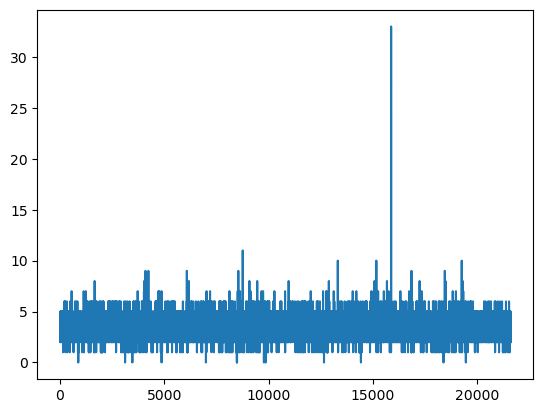

In [82]:
data['bedrooms'].plot()

In [14]:
q = data["bedrooms"].quantile(0.999)
data_no_outliers = data[data['bedrooms']<q]

<AxesSubplot:>

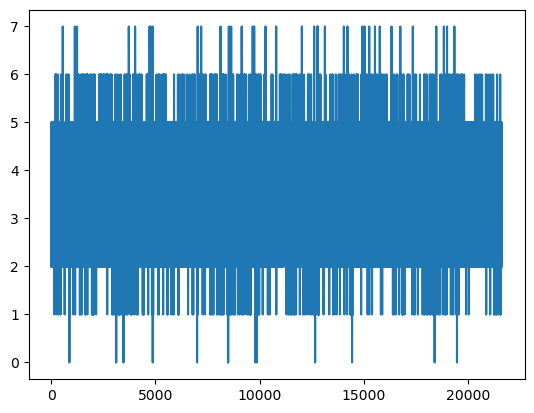

In [15]:
data_no_outliers['bedrooms'].plot()

Now we will setup our training data, split it and convert it to RecordIP format for use in training our Linear Learner model.

In [ ]:
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# S3 bucket for saving code and model artifacts.
bucket = sagemaker.Session().default_bucket()
prefix = "linear-learner" 
output_location = f"s3://{bucket}/{prefix}/output"

In [ ]:
train,val,test = np.split(data_no_outliers.sample(frac=1,random_state=234),[int(0.7*len(data_no_outliers)), int(0.9*len(data_no_outliers))])   

In [21]:
df_train_ll = train.copy()
df_val_ll = val.copy()
df_test_ll = test.copy()

Our model will predict house prices, therefore, we drop 'price' from our data (x) and set it as our label (y)

In [22]:
train_y = df_train_ll.pop('price')
train_x = df_train_ll

In [23]:
val_y = df_val_ll.pop('price')
val_x = df_val_ll

In [24]:
test_y = df_test_ll.pop('price')
test_x = df_test_ll

In [26]:
val_y_ll = val_y.to_numpy(dtype="float32")
val_x_ll = np.array(val_x).astype("float32")

In [27]:
train_y_ll = train_y.to_numpy(dtype="float32")
train_x_ll = np.array(train_x).astype("float32")

In [28]:
test_y_ll = test_y.to_numpy(dtype="float32")
test_x_ll = np.array(test_x).astype("float32")

In [ ]:
#Create a SageMaker session
sagemaker_session = sagemaker.Session()

#Need to convert dataset to RecordIO format for Linear Learner to understand

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, train_x_ll, train_y_ll)
buf.seek(0) 

###Uploading training data
#Filename for training data we are uploading to S3 
key = 'linear-train-data'
#Upload training data to S3
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = f's3://{bucket}/{prefix}/train/{key}'
print(f'uploaded training data location: {s3_train_data}')

###Uploading test data
buf = io.BytesIO() # create an in-memory byte array (buf is a buffer I will be writing to)
smac.write_numpy_to_dense_tensor(buf, test_x_ll, test_y_ll)
buf.seek(0)

#Sub-folder for test data
key = 'linear-test-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test', key)).upload_fileobj(buf)
s3_test_data = f's3://{bucket}/{prefix}/test/{key}'
print(f'uploaded training data location: {s3_test_data}')

###Model Artifacts
output_location = f's3://{bucket}/{prefix}/output'
print(f'Training artifacts will be uploaded to: {output_location}')

While there are many more features we could use and feature engineering we could do, we will stop here and move forward with training our model.

## Step 3 - Train Model using the Linear Learner algorithm


In [ ]:
# Set the container that holds the linear learner algorithm
ll = image_uris.retrieve('linear-learner', region)

# Create the esitmator
linear_model = sagemaker.estimator.Estimator(ll,
                                       role, 
                                       instance_count = 1, 
                                       instance_type = 'ml.m4.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session)

# And set the hyperparameters
linear_model.set_hyperparameters(feature_dim = 77,
                               predictor_type = 'regressor',
                               mini_batch_size = 20,
                               epochs = 5,
                               num_models = 10,
                               loss = 'absolute_loss')

In [83]:
# Now we can pass in S3 training_data path variable we declared earlier and train our first model
linear_model.fit({'train': s3_train_data})

## Step 4 - Deploy Linear Learner the Model

We will now deploy our initial model built using Linear Learner.  

First we will set our endpoint name and model name variables, then we can deploy directly using the .deploy() method.  This will create a new endpoint configuration and endpoint that are hosted by Sagemaker.

We will use the same process when we initially deploy the XGBoost model later in the lab.

In [ ]:
# Set variable names
endpoint_name = 'linear-regressor-endpoint'
linear_model_name = 'linear-regressor-model'

#Deploy our initial model

linear_regressor = linear_model.deploy(initial_instance_count = 1,
                                           instance_type = 'ml.m4.xlarge',
                                           endpoint_name= endpoint_name,
                                           model_name= linear_model_name
                                          )

In [35]:
# We need to make sure the data is in correct format for deployed model
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
linear_regressor.serializer = CSVSerializer()
linear_regressor.deserializer = JSONDeserializer()

## Step 5 - Interact with the Linear Learner model

In a real-world setting, this is where we would be when we first deploy our model.  Since we have a functioning model deployed, we will now push our test data to it.

In [41]:
def invoke_endpoint(endpoint_name):
    limit = 20
    i = 0
    res = []
    with open("data/processed/test/test_x.csv", "r") as f:
        for row in f:
            if i == limit:
                break
            # print(".", end="", flush=True)
            payload = row.rstrip("\n")
            response = sm_runtime.invoke_endpoint(
                EndpointName=endpoint_name, ContentType="text/csv", Body=payload
            )
            print(response['Body'].read())
            x = response["Body"].read()
            res.append(x)
            time.sleep(0.5)
            i +=1
    return res

In [ ]:
invoke_endpoint(endpoint_name)

As you can see - it does ok.  If this were a real-world setting, we would go back and perform further feature engineering.  However, for the purpose of this lab, let's assume that this meets our business needs and thus we begin using the model.

## Step 6 - Train a new model

#### After we have run our model for a time, we decide that a different algorithm may do a better job.  Our first step in replacing our current model is by training a new one.  This could also happen if we were retraining due to concept drift or other events where we needed an updated model but did not want to interupt our production environment.

Now we will train using the same information but using the XGBoost algorithm.  XGBoost requires the input to be in CSV format vs pulling direct from a dataframe as we did above.  Therefore, we will need to setup the train, test and validation data then export it to an S3 bucket in a CSV format.

In [43]:
# Create out train, test and validation sets
train_xgb = train.astype("float32")
val_xgb = val.astype("float32")
test_xgb = test.astype("float32")

In [44]:
test_y_xgb = test_xgb.pop('price')
test_x_xgb = test_xgb

In [51]:
train_xgb.to_csv("data/processed/train/train.csv",header=False,index=False)
val_xgb.to_csv("data/processed/valid/valid.csv",header=False, index=False)
test_x_xgb.to_csv("data/processed/test/test_x.csv",header=False,index=False)
test_y_xgb.to_csv("data/processed/test/test_y.csv",header=False,index=False)

In [ ]:
from sagemaker.s3 import S3Downloader, S3Uploader

# Upload input to the target location
bucket = sagemaker.Session().default_bucket()
prefix = "xgboost_data"
train_s3_url = f"s3://{bucket}/{prefix}/train"
valid_s3_url = f"s3://{bucket}/{prefix}/valid"
test_s3_url = f"s3://{bucket}/{prefix}/test"

In [ ]:
prefix_out = "output"
output_path = f"s3://{bucket}/{prefix_out}/houseing-xgb"

S3Uploader().upload("data/processed/train/train.csv", train_s3_url)
S3Uploader().upload("data/processed/valid/valid.csv", valid_s3_url)
S3Uploader().upload("data/processed/test/test_x.csv", test_s3_url)
S3Uploader().upload("data/processed/test/test_y.csv", test_s3_url)

In [56]:
s3_input_train = TrainingInput(s3_data=f"s3://{bucket}/{prefix}/train/train.csv", content_type='csv')
s3_input_validation = TrainingInput(s3_data=f"s3://{bucket}/{prefix}/valid/valid.csv",content_type='csv')
s3_input_test = TrainingInput(s3_data=f"s3://{bucket}/{prefix}/test/test_x.csv",content_type='csv')

In [ ]:
# Now setup the container, estimator and hyperparameters just as we did with the first model
xgb_image = sagemaker.image_uris.retrieve('xgboost',boto3.Session().region_name,'latest')

data_channels = {'train': s3_input_train, 'validation': s3_input_validation, 'test': s3_input_test}

sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(xgb_image,
                                    role=sagemaker.get_execution_role(), 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path=output_path,
                                    sagemaker_session=sess)

xgb.set_hyperparameters(pobjective="reg:squarederror",
                        max_depth=200,
                        num_round=100)

# and finally train our new model
xgb.fit(data_channels_channels)

## Step 7 - Blue/Green Deployment

We will now deploy our new model with its own endpoint and endpoint configuration.  It will start out as stand alone thus allows us to test it separately if we want.  We will not do this in this lab at this time.

In [ ]:
# Set our variables, then again, use the .deploy() method to deploy our model
xgb_endpoint_name = 'xgb-regressor-endpoint'
xgb_model_name = 'xgb-regressor-model'

xgb_price_regressor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge',
                           endpoint_name = xgb_endpoint_name,
                           model_name = xgb_model_name,
                          )

In [49]:
xgb_price_regressor.serializer = CSVSerializer()
xgb_price_regressor.deserializer = JSONDeserializer()

In [ ]:
invoke_endpoint(xgb_endpoint_name)

## Step 8 - A/B Tests to compare model variants
We can use traffic splitting to direct subsets of users to different model variantsfor the purpose of testing different models in live production. Often, these tests need to run for a long period of time (for weeks) to be statistically significant. In the following we split user traffic 50/50 between the two variants.

In [ ]:
from sagemaker.session import production_variant

variant1 = production_variant(
    model_name=linear_model_name,
    instance_type="ml.m5.xlarge",
    initial_instance_count=50,
    variant_name="linear-learner-variant",
    initial_weight=1,
)
variant2 = production_variant(
    model_name=xgb_model_name,
    instance_type="ml.m5.xlarge",
    initial_instance_count=1,
    variant_name="xgboost-variant",
    initial_weight=50,
)

(variant1, variant2)

In [ ]:
sm_session = session.Session(boto3.Session())

endpoint_name = "home-price-endpoint"
print(f"EndpointName={endpoint_name}")

sm_session.endpoint_from_production_variants(
    name=endpoint_name, production_variants=[variant1, variant2]
)

In [ ]:
invoke_endpoint(endpoint_name)
time.sleep(20)  # give metrics time to catch up

After we have monitored the performance of both models for a period of time, we can shift 100% of the traffic to the better-performing model, in our example from the linear learner model to the XGBoost model.

In [ ]:
sess = sagemaker.Session()
sage_client = sess.sagemaker_client
sage_client.update_endpoint_weights_and_capacities(
    EndpointName=endpoint_name,
    DesiredWeightsAndCapacities=[
        {
            'VariantName': 'linear-learner-variant',
            'DesiredWeight': 0
        },
        {
            'VariantName': 'xgboost-variant',
            'DesiredWeight': 1
        }
    ]
)
response = sess.wait_for_endpoint(endpoint_name)

In [ ]:
invoke_endpoint(endpoint_name)
time.sleep(20) 

## Conclusion

You have now trained and deployed two separate models, and then performed a Blue/Green deployment to switch from one to the other.

## Clean-up

If you're done with this notebook, please run the cell below to remove the hosted endpoint and avoid any charges from any stray instances being left on.

In [ ]:
sagemaker.Session().delete_endpoint(xgb_price_regressor.endpoint_name)
sagemaker.Session().delete_endpoint(home_price_regressor.endpoint_name)